# WaveNet: A generative model for raw audio 

* https://deepmind.com/blog/article/wavenet-generative-model-raw-audio
* 참고: https://github.com/choyi0521/wavenet-pytorch


* WaveNet은 기존의 Text-to-Speech 시스템보다 더 자연스럽고 어떤 사람의 목소리를 흉내내는 스피치를 생성할 수 있다는 것을 보여줌
* WaveNet은 PixelCNN 구조를 기반으로 한 오디오 생성 모델로 보다 자연스러운 음성 신호를 생성 가능

![](https://lh3.googleusercontent.com/XMJlFDtiFU7WtZYnPDMDhT6jTFEXvTpY7c7sY70PtTkzEIDm6DvUv5nvHHwbOrUrDckS34aIu5fiZx0615p1-nf3rFxzhza387ud=w1440-rw-v1)

* 이후 Tacotron, WaveGlow 등 더욱 발전된 모델 개발의 기초가 됨



## 오디오 데이터 준비

* 해당 예제에서는 LJspeech dataset을 사용
* 데이터를 다운로드하기 위해 torchaudio를 설치
* torchaudio를 활용해 LJspeech dataset을 다운로드
* https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2



In [1]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 2.7MB/s 


In [2]:
import torchaudio

LJSpeech_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
train_dataset = torchaudio.datasets.LJSPEECH("", url=LJSpeech_url, download=True)

## 오디오 데이터 변환

* (de)quantize_signal은 데이터를 mu scale로 변환(원 상태로 변환)시켜줌



In [3]:
import numpy as np

def quantize_signal(data, n_class):
    mu_x = np.sign(data) * np.log(1 + n_class * np.abs(data)) / np.log(n_class + 1)
    bins = np.linspace(-1, 1, n_class)
    quantized_data = np.digitize(mu_x, bins) - 1
    return quantized_data

def dequantize_signal(data, n_class):
    data = (data / n_class) * 2. - 1
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(n_class + 1)) - 1) / n_class
    return s

## SpeechDataset

* data 사용을 편리하게 하기 위해 SpeechDataset 객체 정의
  + create_dataset - 다운로드한 audio file을 처리해 dataset으로 구성
  + init_dataset - 데이터셋의 각 항목들을 초기화함
  + \_\_getitme__ - 데이터셋에서 데이터를 꺼낼 때 처리할 코드들을 명시한 함수





In [4]:
from torch.utils.data import Dataset
import numpy as np
import librosa
import random
import torch
import os

class SpeechDataset(Dataset):
    def __init__(self,
                 n_class,
                 slice_length,
                 frame_length,
                 frame_stride,
                 test_size,
                 device,
                 dataset_path='./dataset'):
        self.n_class = n_class
        self.slice_length = slice_length
        self.frame_length = frame_length
        self.frame_stride = frame_stride
        self.test_size = test_size
        self.device = device
        self.dataset_path = dataset_path

    def create_dataset(self, max_files, prefix=None):
        lj_path = './LJSpeech-1.1'
        wav_names = []
        with open(lj_path + '/metadata.csv', encoding='utf-8') as f:
            for line in f:
                name = line.split('|')[0]
                if prefix and name.split('-')[0] != prefix:
                    continue
                wav_names.append(line.split('|')[0])

        random.seed(42)
        random.shuffle(wav_names)
        wav_names = wav_names[:max_files]

        count = 0
        x, cond = None, None
        for wav_name in wav_names:
            wav_path = lj_path + '/wavs/' + wav_name + '.wav'

            # calculate log mel spectrum
            y, sr = librosa.core.load(wav_path)
            input_nfft = int(round(sr * self.frame_length))
            input_stride = int(round(sr * self.frame_stride))
            s = librosa.feature.melspectrogram(y=y, n_mels=N_MELS, n_fft=input_nfft, hop_length=input_stride)
            s = librosa.core.power_to_db(s, ref=np.max)

            # scale to [0, 1]
            s /= 80.0

            new_x = quantize_signal(y, self.n_class)
            new_cond = self.time_resolution(s, y.shape[0])
            print(wav_name, 'processed.')

            if x is None:
                x, cond = new_x, new_cond
            else:
                x, cond = np.concatenate((x, new_x)), np.column_stack((cond, new_cond))

            for i in range(0, x.shape[0]-self.slice_length+1, self.slice_length):
                np.save(self.dataset_path + '/x_' + str(count) + '.npy', x[i:i+self.slice_length])
                np.save(self.dataset_path + '/cond_' + str(count) + '.npy', cond[:, i:i+self.slice_length])
                count += 1

            if x.shape[0] % self.slice_length == 0:
                x, cond = None, None
            else:
                x, cond = x[-x.shape[0]%self.slice_length:], cond[:, -x.shape[0] % self.slice_length:]

    def init_dataset(self, test_mode):
        self.test_mode = test_mode
        file_list = os.listdir(self.dataset_path)
        tot = len(file_list)//2
        self.test_length = int(tot*self.test_size)
        self.train_length = tot-self.test_length

    def __len__(self):
        return self.test_length if self.test_mode else self.train_length

    def __getitem__(self, idx):
        if self.test_mode:
            idx += self.train_length
        x = np.load(self.dataset_path+'/x_'+str(idx)+'.npy')
        cond = np.load(self.dataset_path+'/cond_'+str(idx)+'.npy')

        # one hot encoding
        embedded_x = np.zeros((self.n_class, x.shape[0]))
        embedded_x[x, np.arange(x.shape[0])] = 1

        return torch.tensor(embedded_x[:, :-1], dtype=torch.float, device=self.device),\
               torch.tensor(x[1:], dtype=torch.long, device=self.device),\
               torch.tensor(cond[:, :-1], dtype=torch.float, device=self.device)

    def time_resolution(self, cond, target_length):
        z = np.zeros((cond.shape[0], target_length))
        repeated_cond = np.repeat(cond, target_length//cond.shape[1], axis=1)
        z[:, :repeated_cond.shape[1]] = repeated_cond
        return z

## WaveNet 모델 구성

* WaveNet의 특징으론 Causal Conv와 Residual block, Skip connection이 존재


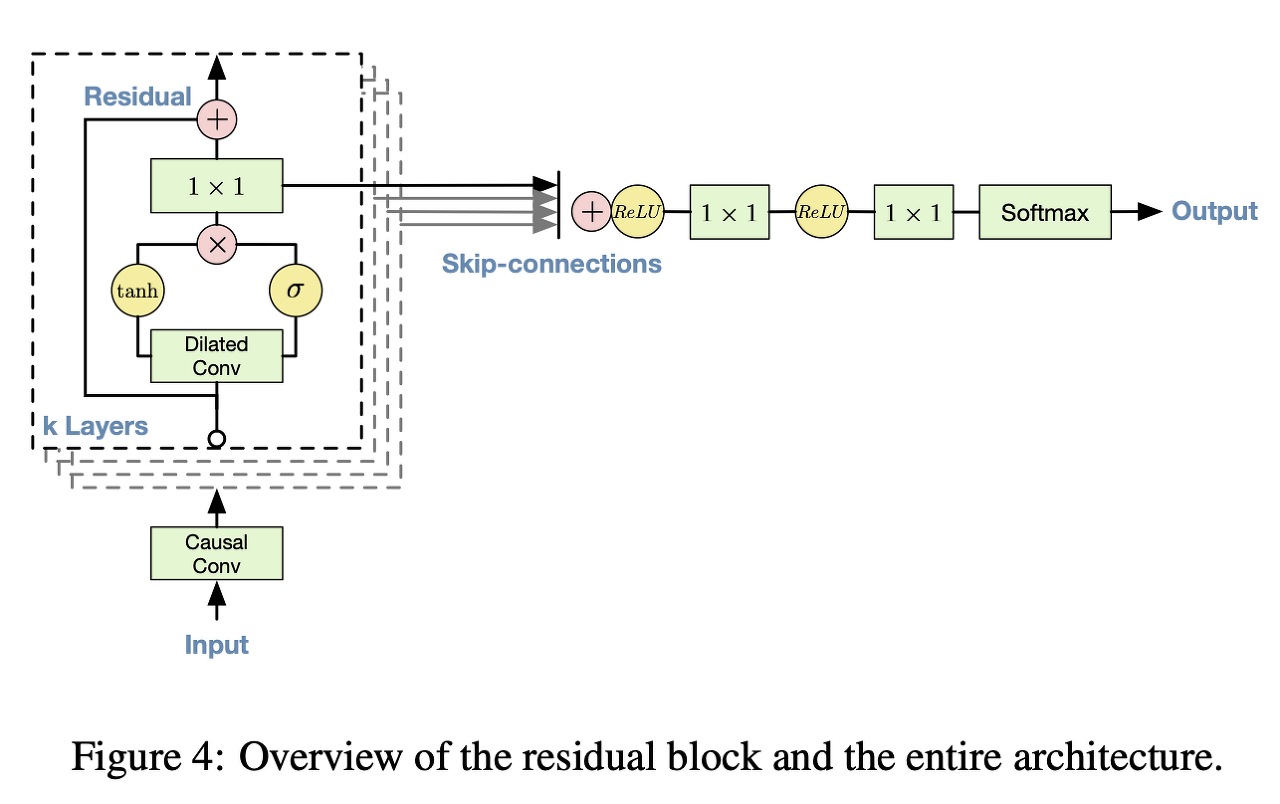

출처 - https://hwiyong.tistory.com/293

In [5]:
import torch.nn as nn
import torch
import numpy as np

class WaveNet(nn.Module):
    def __init__(self, n_class, hidden_channels, cond_channels, n_repeat, n_layer, device):
        super(WaveNet, self).__init__()
        self.n_class = n_class
        self.hidden_channels = hidden_channels

        self.input_conv = nn.Conv1d(in_channels=n_class,
                                    out_channels=hidden_channels,
                                    kernel_size=1)
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.cond_filter_convs = nn.ModuleList()
        self.cond_gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.dilations = []
        self.pad = []

        for _ in range(n_repeat):
            for i in range(n_layer):
                dilation = 2**i
                self.dilations.append(dilation)
                self.pad.append(nn.ConstantPad1d((dilation, 0), 0))
                self.filter_convs.append(nn.Conv1d(in_channels=hidden_channels,
                                                   out_channels=hidden_channels,
                                                   kernel_size=2,
                                                   dilation=dilation))
                self.gate_convs.append(nn.Conv1d(in_channels=hidden_channels,
                                                 out_channels=hidden_channels,
                                                 kernel_size=2,
                                                 dilation=dilation))
                self.cond_filter_convs.append(nn.Conv1d(in_channels=cond_channels,
                                                        out_channels=hidden_channels,
                                                        kernel_size=2,
                                                        dilation=dilation))
                self.cond_gate_convs.append(nn.Conv1d(in_channels=cond_channels,
                                                      out_channels=hidden_channels,
                                                      kernel_size=2,
                                                      dilation=dilation))
                self.residual_convs.append(nn.Conv1d(in_channels=hidden_channels,
                                                     out_channels=hidden_channels,
                                                     kernel_size=1))
                self.skip_convs.append(nn.Conv1d(in_channels=hidden_channels,
                                                 out_channels=hidden_channels,
                                                 kernel_size=1))


        self.output_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                      out_channels=hidden_channels,
                                      kernel_size=1)
        self.output_conv2 = nn.Conv1d(in_channels=hidden_channels,
                                      out_channels=n_class,
                                      kernel_size=1)
        self.relu = nn.ReLU()


        self.max_dilation = max(self.dilations)
        self.device = device
        self.to(device)

    def forward(self, x, cond):
        x = self.input_conv(x)
        skip = torch.zeros((x.shape[0], self.hidden_channels, x.shape[2]),
                           dtype=torch.float,
                           device=self.device)

        for i, dilation in enumerate(self.dilations):
            padded_x = self.pad[i](x)
            padded_cond = self.pad[i](cond)
            fx = self.filter_convs[i](padded_x)
            gx = self.gate_convs[i](padded_x)
            fc = self.cond_filter_convs[i](padded_cond)
            gc = self.cond_gate_convs[i](padded_cond)
            z = torch.tanh(fx+fc)*torch.sigmoid(gx+gc)

            skip += self.skip_convs[i](z)
            x += self.residual_convs[i](z)

        y = self.relu(skip)
        y = self.output_conv1(y)
        y = self.relu(y)
        y = self.output_conv2(y)
        return y

    def generate(self, cond, max_length):
        x = torch.zeros((cond.shape[0], self.n_class, cond.shape[2]),
                            dtype=torch.float,
                            device=self.device)
        x[:, np.random.randint(self.n_class, size=cond.shape[0]), 0] = 1
        res = []
        for i in range(min(cond.shape[2], max_length)):
            y = self.forward(x[:, :, :i+1], cond[:, :, :i+1])
            if i+1 < cond.shape[1]:
                out = np.argmax(y[:, :, i].cpu().detach().numpy(), axis=1)
                x[:, out, i+1] = 1
                res.append(out)
        return np.column_stack(res)

### Stack of Dilated Causal Conv layers

![](https://blog.kakaocdn.net/dn/c7mIvp/btqFJcl0GE5/hmM9P73RfUFu4w8sD4GMSk/img.gif)

* stacked of dilated causal conv layer 구조는 conv layer를 각 층마다 쌓고 dilation을 지정, 다른 unit의 정보(= 이전 시점의 정보)도 받아들임
* WaveNet 모델에서 Conv Layer들을 dilation을 지정해 쌓아 다른 unit의 정보를 얻는 것을 볼 수 있음
* 각 층의 dilation은 보통 층의 개수를 $n$으로 가정, $2^n$으로 지정
* 결국 stacked of dilated causal conv layer 구조는 이전 sequence 정보를 많이 활용하기 위해 사용



### Residual and Skip connection



*   residual and skip connection은 이미지 인식(Resnet)에서 가장 처음 고안된 구조
*   residual은 연산 완료 결과에 연산 전 입력을 더하는 것을 의미
*   skip connection은 연산 결과를 다음 연산에 넘겨줄 뿐만 아니라, 최종 연산에도 전달하는 것을 의미
*   residual and skip connection은 연산 과정에서 손실되는 원본의 정보를 보충해주는 역할
*   결국 residual and skip connection은 더 심층적인 모델 학습을 가능하게 함



In [6]:
def forward(self, x, cond):
        x = self.input_conv(x)
        skip = torch.zeros((x.shape[0], self.hidden_channels, x.shape[2]),
                           dtype=torch.float,
                           device=self.device)

        for i, dilation in enumerate(self.dilations):
            padded_x = self.pad[i](x)
            padded_cond = self.pad[i](cond)
            fx = self.filter_convs[i](padded_x)
            gx = self.gate_convs[i](padded_x)
            fc = self.cond_filter_convs[i](padded_cond)
            gc = self.cond_gate_convs[i](padded_cond)
            z = torch.tanh(fx+fc)*torch.sigmoid(gx+gc)

            skip += self.skip_convs[i](z)
            x += self.residual_convs[i](z)

        y = self.relu(skip)
        y = self.output_conv1(y)
        y = self.relu(y)
        y = self.output_conv2(y)
        return y

In [7]:
# model
COND_CHANNELS = N_MELS
HIDDEN_CHANNELS = 128
N_REPEAT = 2
N_LAYER = 9

NameError: ignored

## Trainer

* 학습을 편리하게 하기 위해 Trainer 객체 생성
  + create_dataset - 앞서 구성한 dataset 객체를 생성하고 필요한 데이터를 구성
  + train - 생성한 데이터를 바탕으로 모델을 통해 학습 진행
  + validate - 평가 데이터를 바탕으로 모델에 대한 성능 평가 진행
  + generate - 데이터를 입력받아 해당 데이터에 해당하는 wav 파일을 생성







In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import librosa
import os

class Trainer(object):
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = WaveNet(N_CLASS, HIDDEN_CHANNELS, COND_CHANNELS, N_REPEAT, N_LAYER, self.device)

        # training state
        self.sample_count = 0
        self.tot_steps = 0

    def create_dataset(self):
        dataset = SpeechDataset(N_CLASS, SLICE_LENGTH, FRAME_LENGTH, FRAME_STRIDE, TEST_SIZE, self.device)
        dataset.create_dataset(MAX_FILES, FILE_PREFIX)

    def train(self):
        self.model.train()
        dataset = SpeechDataset(N_CLASS, SLICE_LENGTH, FRAME_LENGTH, FRAME_STRIDE, TEST_SIZE, self.device)
        dataset.init_dataset(test_mode=False)
        data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        for epoch in range(MAX_EPOCHS):
            for i, data in enumerate(data_loader):
                x, y, cond = data
                pred_y = self.model(x, cond)
                loss = F.cross_entropy(pred_y, y)
                optimizer.zero_grad()
                loss.backward()
                clip_grad_norm_(self.model.parameters(), MAX_NORM)
                optimizer.step()

                if i % PRINT_FREQ == 0:
                    print('epoch: %d, step:%d, tot_step:%d, loss: %f'%(epoch, i, self.tot_steps, loss.item()))
                if i % VALID_FREQ == 0:
                    self.validate()
                    self.model.eval()
                self.tot_steps += 1

    def validate(self):
        self.model.eval()
        dataset = SpeechDataset(N_CLASS, SLICE_LENGTH, FRAME_LENGTH, FRAME_STRIDE, TEST_SIZE, self.device)
        dataset.init_dataset(test_mode=True)
        data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
        res = []
        for i, data in enumerate(data_loader):
            if i == MAX_VALID:
                break
            x, y, cond = data
            pred_y = self.model(x, cond)
            loss = F.cross_entropy(pred_y.squeeze(), y.squeeze())
            res.append(loss.item())
        print('valid loss: '+str(sum(res)/len(res)))

    def generate(self):
        self.model.eval()
        dataset = SpeechDataset(N_CLASS, SLICE_LENGTH, FRAME_LENGTH, FRAME_STRIDE, TEST_SIZE, self.device)
        dataset.init_dataset(test_mode=True)
        data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
        for i, data in enumerate(data_loader):
            if i == MAX_GENERATE:
                break
            _, _, cond = data
            res = self.model.generate(cond, MAX_GENERATE_LENGTH)
            res = dequantize_signal(res, N_CLASS)
            for j in range(res.shape[0]):
                librosa.output.write_wav('./samples/sample%d.wav'%(self.sample_count), res[j], SAMPLE_RATE)
                self.sample_count += 1



*   data loader에서 사용되는 각 파라미터들을 정의
*   각 파라미터에 대한 설명은 주석을 참조



In [ ]:
N_CLASS = 256 # 양자화에 사용될 클래스 크기
FRAME_LENGTH = 0.025 # 프레임의 길이
FRAME_STRIDE = 0.010 # 프레임 간의 간격
N_MELS = 40 # melspectrogram 생성 시 크기
BATCHES = 100
SLICE_LENGTH = 8193 # 데이터를 자를때의 길이
TEST_SIZE = 0.1 # 성능 평가에 사용될 데이터셋의 크기 지정
FILE_PREFIX = 'LJ001'
MAX_FILES = 5 # 학습에 사용될 파일의 개수



*   학습때 필요한 파라미터들을 정의


In [ ]:
# training
BATCH_SIZE = 4 
MAX_EPOCHS = 50
MAX_NORM = 4
LEARNING_RATE = 0.0001

PRINT_FREQ = 1
VALID_FREQ = 100
INFER_FREQ = 100
MAX_VALID = 1

*   생성때 필요한 파라미터들을 정의

In [ ]:
# generate
MAX_GENERATE = 1
MAX_GENERATE_LENGTH = 4096
SAMPLE_RATE = 22050



*   앞서 생성한 객체들을 구성해 학습 진행



In [ ]:
tr = Trainer()

os.mkdir('./dataset')
os.mkdir('./samples')

tr.create_dataset()
tr.train()

## 오디오 파일 생성

* 학습이 끝난 Trainer 객체를 사용해 wav 파일 생성
* 생성된 wav 파일 확인



In [ ]:
tr.generate()

In [ ]:
import glob
import IPython.display as ipd

path = glob.glob('./samples/*.wav')[0]
ipd.Audio(path)